In [1]:
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
df = pd.read_csv("OxCGRT_raw_USA_v1.csv")

/var/folders/4c/sd5grc691sx_dp1xqn1s9dyc0000gq/T/ipykernel_1486/3994568911.py:1: DtypeWarning: Columns (65,67,76,78) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("OxCGRT_raw_USA_v1.csv")


In [3]:
for col in df.columns:
    print(col)

CountryName
CountryCode
RegionName
RegionCode
Jurisdiction
Date
C1E_School closing
C1E_Flag
C1NV_School closing
C1NV_Flag
C1V_School closing
C1V_Flag
C1_Notes
C2E_Workplace closing
C2E_Flag
C2NV_Workplace closing
C2NV_Flag
C2V_Workplace closing
C2V_Flag
C2_Notes
C3E_Cancel public events
C3E_Flag
C3NV_Cancel public events
C3NV_Flag
C3V_Cancel public events
C3V_Flag
C3_Notes
C4E_Restrictions on gatherings
C4E_Flag
C4NV_Restrictions on gatherings
C4NV_Flag
C4V_Restrictions on gatherings
C4V_Flag
C4_Notes
C5E_Close public transport
C5E_Flag
C5NV_Close public transport
C5NV_Flag
C5V_Close public transport
C5V_Flag
C5_Notes
C6E_Stay at home requirements
C6E_Flag
C6NV_Stay at home requirements
C6NV_Flag
C6V_Stay at home requirements
C6V_Flag
C6_Notes
C7E_Restrictions on internal movement
C7E_Flag
C7NV_Restrictions on internal movement
C7NV_Flag
C7V_Restrictions on internal movement
C7V_Flag
C7_Notes
C8E_International travel controls
C8NV_International travel controls
C8V_International travel 

In [9]:
c1_cols = ["C1E_School closing", "C1_Notes"]
index_cols = ["CountryName", "CountryCode", "RegionName", "RegionCode", "Date"]
c1 = df[index_cols + c1_cols]
c1 = c1.dropna(subset=["C1_Notes"])
c1 = c1[c1["RegionCode"] == "NAT_TOTAL"]
c1 = c1.sort_values(by="Date")
for i in range(20):
    print(c1["C1E_School closing"].iloc[i])
    print(c1["Date"].iloc[i])
    print(c1["C1_Notes"].iloc[i])

3.0
20200305
Washington District Shuts Down All Schools to Slow Deadly Coronavirus Outbreak Link: http://web.archive.org/web/20201104100007/https://www.thedailybeast.com/northshore-school-district-shuts-down-all-schools-to-slow-deadly-coronavirus-outbreak
3.0
20200411
Education trade publication's tracker of school closures. Link not archivable. https://www.edweek.org/ew/section/multimedia/map-coronavirus-and-school-closures.html  
3.0
20200416
Education trade publication's tracker of school closures. As of 16/04, South Dakota, Tennessee, Maine, Idaho, and California only recommend, but not require all schools to close. http://web.archive.org/web/20201031020101/https://www.edweek.org/ew/section/multimedia/map-coronavirus-and-school-closures.html
3.0
20200423
All states have now ordered schools to close through the end of the school year, with a few exceptions (Wyoming schools ordered closed through 30 April, Montana through 6 May, New York & New Jersey through 15 May, etc.). Per tracke

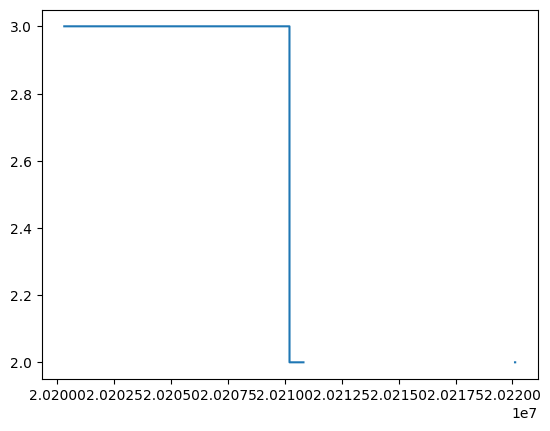

In [5]:
fig, ax = plt.subplots()
ax.plot(c1["Date"], c1["C1E_School closing"])
plt.show()

In [8]:
pd.to_datetime("20200301")

Timestamp('2020-03-01 00:00:00')

In [11]:
def create_initial_persistence():
    rows = []
    rows.append({"date": pd.to_datetime("November 28 2020"), "region": "United States", "criterion": "C1E", "score": 3})
    rows.append({"date": pd.to_datetime("September 14 2024"), "region": "United States", "criterion": "C1E", "score": 0})

    df = pd.DataFrame(rows)
    df.to_csv("persistence.csv", index=False)

create_initial_persistence()